In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List
import random
import time

from tqdm.notebook import tqdm

In [2]:
random.seed(1234)

In [3]:
df = pd.read_csv('data/geolife-cars-upd8.csv')

In [4]:
df.head

<bound method NDFrame.head of                         id_          x         y
0        115-20080639247416  16.375738  0.323612
1        115-20080639247416  16.350164  0.322686
2        115-20080639247416  16.320867  0.321954
3        115-20080639247416  16.292414  0.321813
4        115-20080639247416  16.263141  0.320450
...                     ...        ...       ...
1326397  115-20080647739963  -6.388940  7.578725
1326398  115-20080647739963  -6.389568  7.550605
1326399  115-20080647739963  -6.387959  7.524640
1326400  115-20080647739963  -6.371967  7.506200
1326401  115-20080647739963  -6.350408  7.495665

[1326402 rows x 3 columns]>

In [5]:
#getting all the ids of the trajectories
ids = []
for ind in df.index:
    id = df['id_'][ind]
    ids.append(id)

#removing duplicate ids
res = [*set(ids)]

In [6]:
#getting trajectory data
data = []
for t_id in res:
    traj = df[df["id_" ] == t_id]
    t = list(zip(traj.x, traj.y))
    data.append(t)

In [7]:
#helper function: finding distance between a point q and a line e
def d(q: Tuple[float, float], e: List[Tuple[float, float]]) -> float:
    """
    Computes the distance between a point q and a line segment e.

    Args:
        q: A tuple representing the point q.
        e: A list representing the line segment e as (a, b).

    Returns:
        The distance between the point q and the line segment e.
    """
    # Let the start point of e be a, and end point be b 
    a, b = e
    # Compute the dot product of vectors aq and ab
    dot_product = (q[0] - a[0]) * (b[0] - a[0]) + (q[1] - a[1]) * (b[1] - a[1])
    # Compute the length of ab (squared)
    ab_length_sq = (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2
    # Compute the projection of vector aq onto vector ab
    projection = dot_product / ab_length_sq
    if projection <= 0:
        # Point q is closest to the start point (a) of line segment e
        return ((q[0] - a[0]) ** 2 + (q[1] - a[1]) ** 2) ** 0.5
    elif projection >= 1:
        # Point q is closest to the end point (b) of line segment e 
        return ((q[0] - b[0]) ** 2 + (q[1] - b[1]) ** 2) ** 0.5
    else:
        # Point q is closest to the point on line segment e between its start (a) and end (b) points
        closest_x = a[0] + projection * (b[0] - a[0])
        closest_y = a[1] + projection * (b[1] - a[1])
        return ((q[0] - closest_x) ** 2 + (q[1] - closest_y) ** 2) ** 0.5

In [8]:
#helper function: computes an epsilon-simplification of the trajectory T using a greedy algorithm
def TS_greedy(T: List[Tuple[float, float]], eps: float) -> List[Tuple[float, float]]:
    """
    Computes an epsilon-simplification of the trajectory T using a greedy algorithm.

    Arguments:
        T: A list of tuples representing the trajectory T as [(x1, y1), ..., (xn, yn)].
        eps: A float number representing the maximum error of the simplification.

    Returns:
        A list of tuples representing the epsilon-simplification of the trajectory T.
    """
    if len(T) < 3:
        # Base case, the trajectory cannot be simplified further
        return T
    else:
        # Initialize the simplified trajectory, T_star, with the first and last points of the trajectory
        T_star = [T[0], T[-1]]
        # Find the point with max distance
        dmax = 0
        index = 0
        for i in range(1, len(T) - 1):
            dis = d(T[i], T_star)
            if dis > dmax:
                index = i 
                dmax = dis
        # Check if the epsilon criterion is met
        if dmax <= eps: 
            # T_star is sufficient to represent the current trajectory within max error epsilon
            return T_star 
        else:
            # Max distance > epsilon
            # Recurse on left and right, seperated by the point with max distance;
            return TS_greedy(T[0:index], eps) + TS_greedy(T[index:], eps) 

In [9]:
#helper function: computes Euclidean distance
def dist(a, b):
    return ((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) ** 0.5

In [10]:
#helper function: modified dtw distance
def dtw(seriesA, seriesB):
    m, n = len(seriesA) + 1, len(seriesB) + 1
    dp = [[[float('inf'), set()] for _ in range(n)] for _ in range(m)]
    dp[0][0] = [0, None]

    for i in range(m - 1):
        for j in range(n - 1):
            curr = dp[i][j]
            curr[0] += dist(seriesA[i], seriesB[j])
            if curr[0] < dp[i + 1][j][0]: dp[i + 1][j] = [curr[0], (i, j)]
            if curr[0] < dp[i][j + 1][0]: dp[i][j + 1] = [curr[0], (i, j)]
            if curr[0] < dp[i + 1][j + 1][0]: dp[i + 1][j + 1] = [curr[0], (i, j)]
    
    total_cost, last = dp[len(seriesA) - 1][len(seriesB) - 1]
    
    path = {(len(seriesA) - 1, len(seriesB) - 1)}
    while last is not None:
        path.add(last)
        last = dp[last[0]][last[1]][1]

    return total_cost / len(path), path

In [16]:
#helper function: modified Frechet distance 
def fd(seriesA, seriesB):
    m, n = len(seriesA) + 1, len(seriesB) + 1
    dp = [[[float('inf'), set()] for _ in range(n)] for _ in range(m)]
    dp[0][0] = [0, None]

    for i in range(m - 1):
        for j in range(n - 1):
            curr = dp[i][j]
            curr[0] = max(curr[0], dist(seriesA[i], seriesB[j]))
            if curr[0] < dp[i + 1][j][0]: dp[i + 1][j] = [curr[0], (i, j)]
            if curr[0] < dp[i][j + 1][0]: dp[i][j + 1] = [curr[0], (i, j)]
            if curr[0] < dp[i + 1][j + 1][0]: dp[i + 1][j + 1] = [curr[0], (i, j)]
    
    total_cost, last = dp[len(seriesA) - 1][len(seriesB) - 1]
    
    path = {(len(seriesA) - 1, len(seriesB) - 1)}
    while last is not None:
        path.add(last)
        last = dp[last[0]][last[1]][1]
    
    return total_cost, path

In [17]:
#helper function: interpolates equidistant points along each trajectory by linearly interpolating between points
def interpolate(trajectories, num_points):
    """
    Interpolates equidistant points along each trajectory by linearly interpolating between points.

    Args:
        trajectories (list): List of trajectories, where each trajectory is a list of tuples with x and y coordinates.
        num_points (int): Number of equidistant points to interpolate.

    Returns:
        list: List of tuples containing interpolated x and y values for each trajectory.
    """
    interpolated_trajectories = []
    for trajectory in trajectories:
        x = [point[0] for point in trajectory]
        y = [point[1] for point in trajectory]
        total_distance = 0.0
        distances = [0.0]

        # Compute distances between consecutive points
        for i in range(1, len(x)):
            distance = ((x[i] - x[i - 1]) ** 2 + (y[i] - y[i - 1]) ** 2) ** 0.5
            total_distance += distance
            distances.append(total_distance)

        # Compute the spacing between equidistant points
        spacing = total_distance / (num_points - 1)

        # Interpolate y-values at equidistant points
        interpolated_y = []
        interpolated_x = []
        current_point = 0
        for i in range(num_points):
            parameter = i * spacing

            # Find the segment where the parameter falls
            while distances[current_point] < parameter and current_point < len(distances)-1:
                current_point += 1

            # Perform linear interpolation between consecutive points
            x1, y1 = x[current_point - 1], y[current_point - 1]
            x2, y2 = x[current_point], y[current_point]
            segment_length = distances[current_point] - distances[current_point - 1]
            t = (parameter - distances[current_point - 1]) / segment_length
            interpolated_x.append(x1 + (x2 - x1) * t)
            interpolated_y.append(y1 + (y2 - y1) * t)

        interpolated_trajectory = list(zip(interpolated_x, interpolated_y))
        interpolated_trajectories.append(interpolated_trajectory)

    return interpolated_trajectories

In [18]:
#helper function:
def compute_average_trajectory(trajectories):
    interpolated_trajectories = trajectories
    num_points = len(interpolated_trajectories[0])
    avg_trajectory = []

    for i in range(num_points-1):
        total_x = 0.0
        total_y = 0.0
        for trajectory in interpolated_trajectories:
            total_x += trajectory[i][0]
            total_y += trajectory[i][1]
        avg_x = total_x / len(interpolated_trajectories)
        avg_y = total_y / len(interpolated_trajectories)
        avg_trajectory.append((avg_x, avg_y))

    return avg_trajectory

In [19]:
#helper function: finding center trajectory using approach ii from task 4
#modified for dealing with empty set
def find_center_trajectory(trajectories):
    total_points = 0
    for trajectory in trajectories:
        total_points += len(trajectory)
    if len(trajectories) == 0:
        num_points = 0
        return [], 0, []
    else:
        num_points = int(total_points / len(trajectories))
    
    interpolated_trajectories = interpolate(trajectories, num_points)
    avg_trajectory = compute_average_trajectory(interpolated_trajectories)
    return avg_trajectory, num_points, interpolated_trajectories

In [20]:
#helper function: randomly partition trajectories into k clusters
def partition(traj, k):
    random.shuffle(traj)  
    return [traj[i::k] for i in range(k)]

In [15]:
#4.2.1 implementation
def lloyd_random(trajectories, k, eps, t, isSimplified):
    #simplifyng all the trajectories with an epsilon eps to improve runtime
    #if isSimplified is true, it means that the trajectories are already simplified (to save runtime)
    if not isSimplified:
        trajectories = [TS_greedy(traj, eps) for traj in trajectories]
        
        
    #partition the trajectories into k sets randomly
    traj_cluster = partition([*trajectories], k)
    
    center = []
    cost_track = []
    
    #initialize
    for cluster in traj_cluster:
        avg_trajectory, num_points, interpolated_trajectories = find_center_trajectory(cluster)
        center.append(avg_trajectory)
    
    #iterate t times
    for i in range(0, t):
        new_cluster = [list() for _ in traj_cluster]
        indices = []
        new_center = []
        cost = 0
        
        for trajectory in trajectories:
            
            #get the distance to all centers
            all_center_dist = [dtw(c, trajectory)[0] for c in center if len(c) > 0]
            
            #get the index of the closest center
            closest = min(enumerate(all_center_dist), key=lambda i: i[1])[0]
            indices.append(closest)
            cost += min(all_center_dist)
            
            #add to the cluster
            new_cluster[closest].append(trajectory)
        
        traj_cluster = new_cluster
        cost_track.append(cost)
        
        j = 0
        for c in traj_cluster:
            if len(c) > 0:
                new_center.append(find_center_trajectory(c)[0])
            else:
                new_center.append(center[j])
            j += 1
        #if two centers are the same, return
        if center == new_center:
            print(i + 1, "terminates")
            return indices, center, cost_track
        else:
            center = new_center
        
        
    #return a list of index corresponding to the cluster of the trajectory, and the list of the center of clusters
    return indices, center, cost, cost_track

In [107]:
%%time
#testing 4.2.1
#with simplified trajectories
#lloyd_random(tqdm(temp), 4, 0.08, 12, True)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11 µs


In [22]:
#4.1.1 seeding design

#randomly select a trajectory as the first center
#compute its distances to all other trajectories (distance is calculated by fd)
#select the traj with largest dist as the second center
#compute all other factories' dist to existing centers, find the one with largest sum of distances
#selecte the traj as the third center
#repeat until k centers are selected
def seeding(traj, k):
    #return k centers from simplified trajectories
    
    center = []
    #assuming the input trajectories are simplified
    #first center is random
    index = random.randint(0, len(traj)-1)
    center.append(traj[index])
    
    max_dist = 0
    new_center = 0
    
    while(len(center) < k):
        for i in range(0, len(traj)):
            t = traj[i]
            all_center_dist = [fd(t, c)[0] for c in center if len(c) > 0]
            sum_dist =  sum(all_center_dist)
            if sum_dist > max_dist:
                max_dist = sum_dist
                new_center = i
        center.append(traj[new_center])

    return center

In [21]:
#simplified trajectory data with epsilon = 0.05
temp = [TS_greedy(traj, 0.05) for traj in data]

In [45]:
#4.2.2 implementation: modified Lloyld's algorithm
#if isSeeding is true, use proposed seeding method
def lloyd_modified(trajectories, k, eps, t, isSeeding, isSimplified):
    #simplifyng all the trajectories with an epsilon eps to improve runtime
    #if isSimplified is true, it means that the trajectories are already simplified (to save runtime)
    if not isSimplified:
        trajectories = [TS_greedy(traj, eps) for traj in trajectories]
    
    center = []
    cost_track = []
    
    if isSeeding:
        center = seeding(trajectories, k)
    else:
        #partition the trajectories into k sets randomly
        traj_cluster = partition([*trajectories], k)
        #initialize random centers
        for cluster in traj_cluster:
            avg_trajectory, num_points, interpolated_trajectories = find_center_trajectory(cluster)
            center.append(avg_trajectory)
    
    #iterate t times
    for i in range(0, t):
        indices = []
        new_center = []
        cost = 0
        
        for trajectory in trajectories:
            new_cluster = [list() for _ in center]
            
            #get the distance to all centers
            all_center_dist = [dtw(c, trajectory)[0] for c in center if len(c) > 0]
            
            #get the index of the closest center
            closest = min(enumerate(all_center_dist), key=lambda i: i[1])[0]
            indices.append(closest)
            
            cost += min(all_center_dist)
            
            #add to the cluster
            new_cluster[closest].append(trajectory)
            
        cost_track.append(cost) 
        traj_cluster = new_cluster
        
        j = 0
        for c in traj_cluster:
            if len(c) > 0:
                new_center.append(find_center_trajectory(c)[0])
            else:
                new_center.append(center[j])
            j += 1
        #if two centers are the same, return
        if center == new_center:
            print("terminates")
            iteration = i + 1
            return indices, center, cost, cost_track, iteration
        else:
            center = new_center
            
    #return a list of index corresponding to the cluster of the trajectory, and the list of the centers of clusters
    return indices, center, cost, cost_track, t

In [106]:
%%time
#testing 4.2.2
#with simplified trajectories
#lloyd_modified(temp, 6, 0.08, 10, False, True)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 14.8 µs


In [ ]:
#4.2.3 implementation

In [36]:
#simplified trajectory data with epsilon = 0.1
temp = [TS_greedy(traj, 0.08) for traj in data]

In [73]:
random_sum = []
random_it = []

In [74]:
seeding_sum = []
seeding_it = []
seeding_center = []

In [46]:
#k = 4, random
cost_sum = 0
cost_it = []
center_traj = []
for i in range (0, 3):
    indices, center, cost, cost_track, iteration = lloyd_modified(temp, 4, 0.08, 10, False, True)
    cost_sum += cost
    cost_it.append(cost_it)
average = cost_sum / 3
print(average, cost_it)

terminates
terminates
terminates
2031.5130156008981 [[...], [...], [...]]


In [76]:
random_sum.append(average)

In [56]:
#k = 4, seeding
cost_sum = 0
cost_it = []
center_traj = []
indice = []
for i in range (0, 3):
    indices, center, cost, cost_track, iteration = lloyd_modified(temp, 4, 0.08, 10, True, True)
    cost_sum += cost
    cost_it.append(cost_it)
    center_traj.append(center)
    indice.append(indices)
average = cost_sum / 3
print(average, cost_it)

terminates
terminates
terminates
1289.4350354711435 [[...], [...], [...]]


In [83]:
seeding_sum.append(1289.4350354711435)

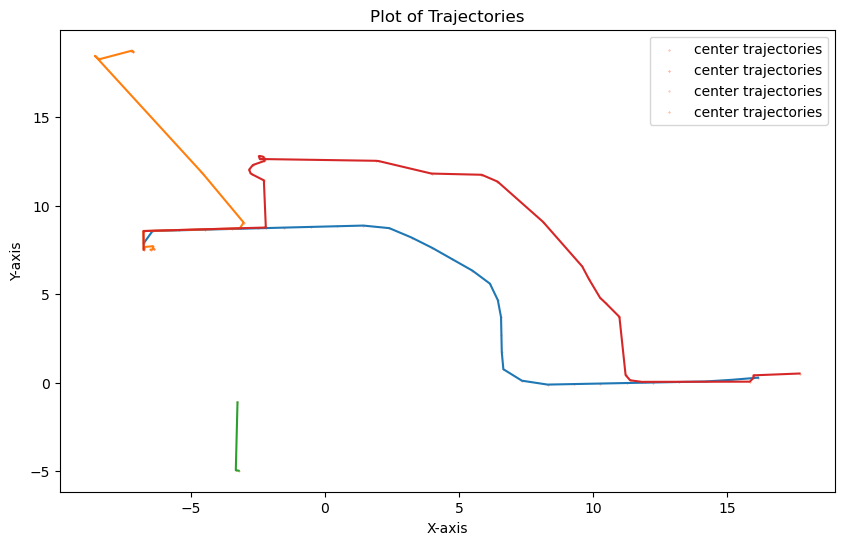

In [59]:
colors = ['salmon',
'tomato',
'darksalmon',
'coral',
'orangered',
'lightsalmon',
'sienna',
'seashell',
'chocolate',
'saddlebrown', 'lightgreen' ]

fig, ax = plt.subplots(figsize=(10,6))
counter = 0

for points in center_traj[0]:
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    ax.scatter(x, y, c=colors[counter], label='center trajectories', s =0.1)  # Use the c parameter to specify the color, marker parameter to specify the marker shape, and linestyle parameter to specify the line style
    ax.plot(x,y)
    counter = counter +1
    
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

ax.set_title('Plot of Trajectories')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()

In [48]:
#k = 6, random
cost_sum = 0
cost_it = []
center_traj = []
for i in range (0, 3):
    indices, center, cost, cost_track, iteration = lloyd_modified(temp, 6, 0.08, 10, False, True)
    cost_sum += cost
    cost_it.append(cost_it)
average = cost_sum / 3
print(average, cost_it)

terminates
terminates
terminates
2021.2939179043417 [[...], [...], [...]]


In [78]:
random_sum.append(2021.2939179043417)

In [60]:
#k = 6, seeding
cost_sum = 0
cost_it = []
center_traj = []
indice = []
for i in range (0, 3):
    indices, center, cost, cost_track, iteration = lloyd_modified(temp, 6, 0.08, 10, True, True)
    cost_sum += cost
    cost_it.append(cost_it)
    center_traj.append(center)
    indice.append(indices)
average = cost_sum / 3
print(average, cost_it)

terminates
terminates
terminates
1159.3859929798407 [[...], [...], [...]]


In [84]:
seeding_sum.append(1159.3859929798407)

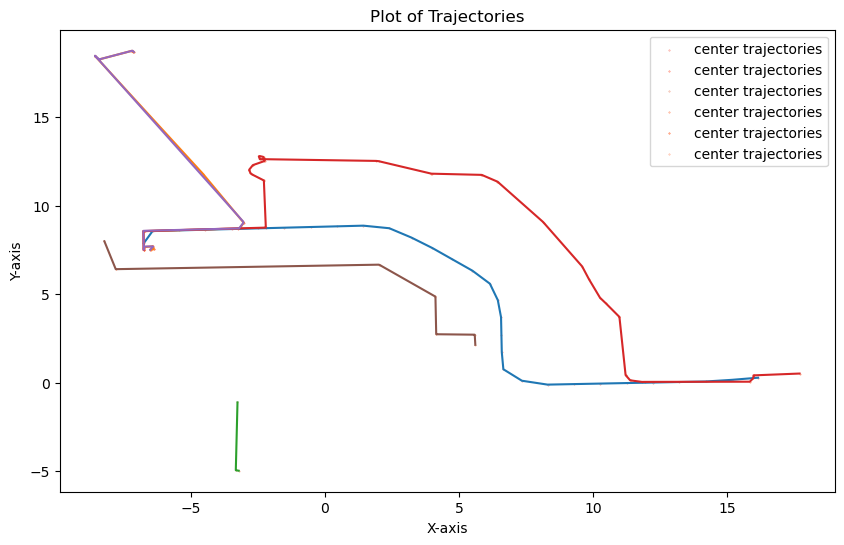

In [61]:
colors = ['salmon',
'tomato',
'darksalmon',
'coral',
'orangered',
'lightsalmon',
'sienna',
'seashell',
'chocolate',
'saddlebrown', 'lightgreen' ]

fig, ax = plt.subplots(figsize=(10,6))
counter = 0

for points in center_traj[0]:
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    ax.scatter(x, y, c=colors[counter], label='center trajectories', s =0.1)  # Use the c parameter to specify the color, marker parameter to specify the marker shape, and linestyle parameter to specify the line style
    ax.plot(x,y)
    counter = counter +1
    
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

ax.set_title('Plot of Trajectories')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()

In [50]:
#k = 8, random
cost_sum = 0
cost_it = []
center_traj = []
for i in range (0, 3):
    indices, center, cost, cost_track, iteration = lloyd_modified(temp, 8, 0.08, 10, False, True)
    cost_sum += cost
    cost_it.append(cost_it)
average = cost_sum / 3
print(average, cost_it)

terminates
terminates
terminates
2005.455090487569 [[...], [...], [...]]


In [79]:
random_sum.append(2005.455090487569)

In [62]:
#k = 8, seeding
cost_sum = 0
cost_it = []
center_traj = []
indice = []
for i in range (0, 3):
    indices, center, cost, cost_track, iteration = lloyd_modified(temp, 8, 0.08, 10, True, True)
    cost_sum += cost
    cost_it.append(cost_it)
    center_traj.append(center)
    indice.append(indices)
average = cost_sum / 3
print(average, cost_it)

terminates
terminates
terminates
1054.264903700124 [[...], [...], [...]]


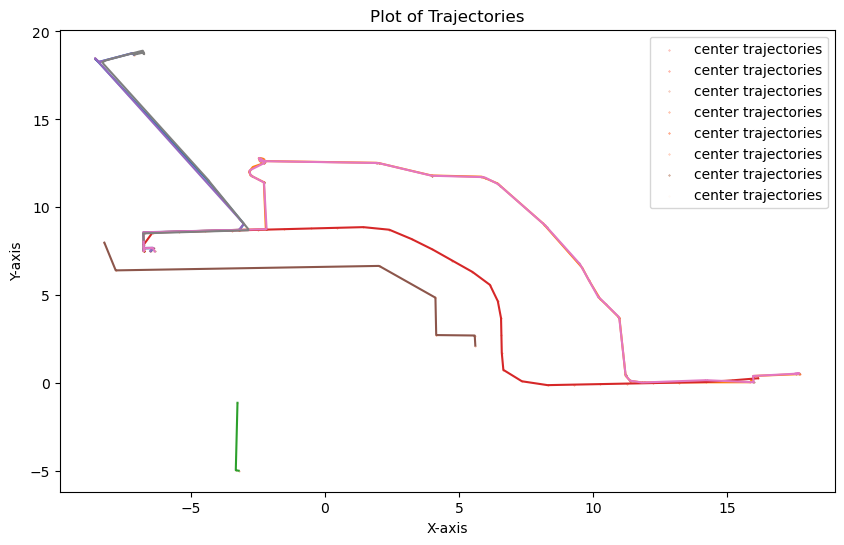

In [64]:
colors = ['salmon',
'tomato',
'darksalmon',
'coral',
'orangered',
'lightsalmon',
'sienna',
'seashell',
'chocolate',
'saddlebrown', 'lightgreen' ]

fig, ax = plt.subplots(figsize=(10,6))
counter = 0

for points in center_traj[0]:
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    ax.scatter(x, y, c=colors[counter], label='center trajectories', s =0.1)  # Use the c parameter to specify the color, marker parameter to specify the marker shape, and linestyle parameter to specify the line style
    ax.plot(x,y)
    counter = counter +1
    
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

ax.set_title('Plot of Trajectories')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()

In [85]:
seeding_sum.append(1054.264903700124)

In [52]:
#k = 10, random
cost_sum = 0
cost_it = []
center_traj = []
for i in range (0, 3):
    indices, center, cost, cost_track, iteration = lloyd_modified(temp, 10, 0.08, 10, False, True)
    cost_sum += cost
    cost_it.append(cost_it)
average = cost_sum / 3
print(average, cost_it)

terminates
terminates
terminates
2002.1816535833295 [[...], [...], [...]]


In [80]:
random_sum.append(2002.1816535833295)

In [68]:
#k = 10, seeding
cost_sum = 0
cost_it = []
center_traj = []
indice = []
for i in range (0, 3):
    indices, center, cost, cost_track, iteration = lloyd_modified(temp, 10, 0.08, 10, True, True)
    cost_sum += cost
    cost_it.append(cost_it)
    center_traj.append(center)
    indice.append(indices)
average = cost_sum / 3
print(average, cost_it)

terminates
terminates
terminates
1052.5586561161595 [[...], [...], [...]]


In [86]:
seeding_sum.append(1052.5586561161595)

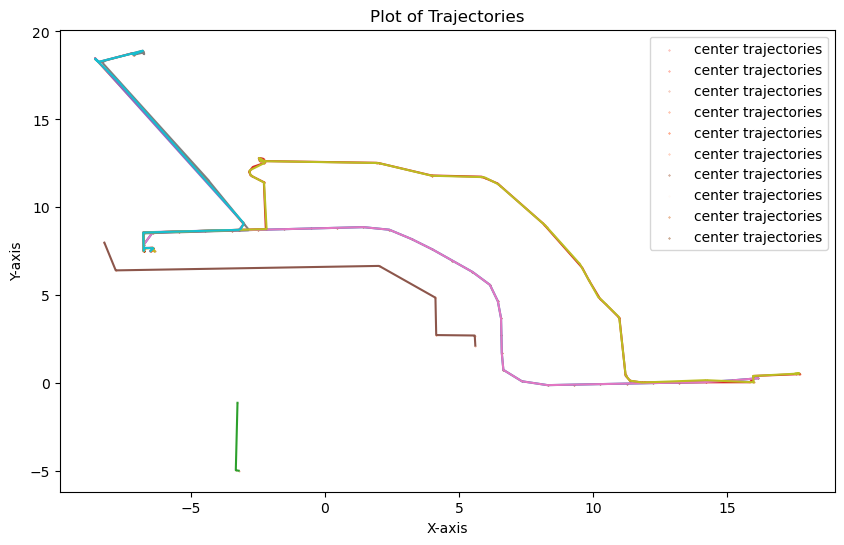

In [69]:
colors = ['salmon',
'tomato',
'darksalmon',
'coral',
'orangered',
'lightsalmon',
'sienna',
'seashell',
'chocolate',
'saddlebrown', 'lightgreen' ]

fig, ax = plt.subplots(figsize=(10,6))
counter = 0

for points in center_traj[0]:
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    ax.scatter(x, y, c=colors[counter], label='center trajectories', s =0.1)  # Use the c parameter to specify the color, marker parameter to specify the marker shape, and linestyle parameter to specify the line style
    ax.plot(x,y)
    counter = counter +1
    
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

ax.set_title('Plot of Trajectories')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()

In [54]:
#k = 12, random
cost_sum = 0
cost_it = []
center_traj = []
for i in range (0, 3):
    indices, center, cost, cost_track, iteration = lloyd_modified(temp, 12, 0.08, 10, False, True)
    cost_sum += cost
    cost_it.append(cost_it)
average = cost_sum / 3
print(average, cost_it)

terminates
terminates
terminates
2004.7950890397585 [[...], [...], [...]]


In [81]:
random_sum.append(2004.7950890397585)

In [70]:
#k = 12, seeding
cost_sum = 0
cost_it = []
center_traj = []
indice = []
for i in range (0, 3):
    indices, center, cost, cost_track, iteration = lloyd_modified(temp, 12, 0.08, 10, True, True)
    cost_sum += cost
    cost_it.append(cost_it)
    center_traj.append(center)
    indice.append(indices)
average = cost_sum / 3
print(average, cost_it)

terminates
terminates
terminates
1051.5511882116566 [[...], [...], [...]]


In [87]:
seeding_sum.append(1051.5511882116566)

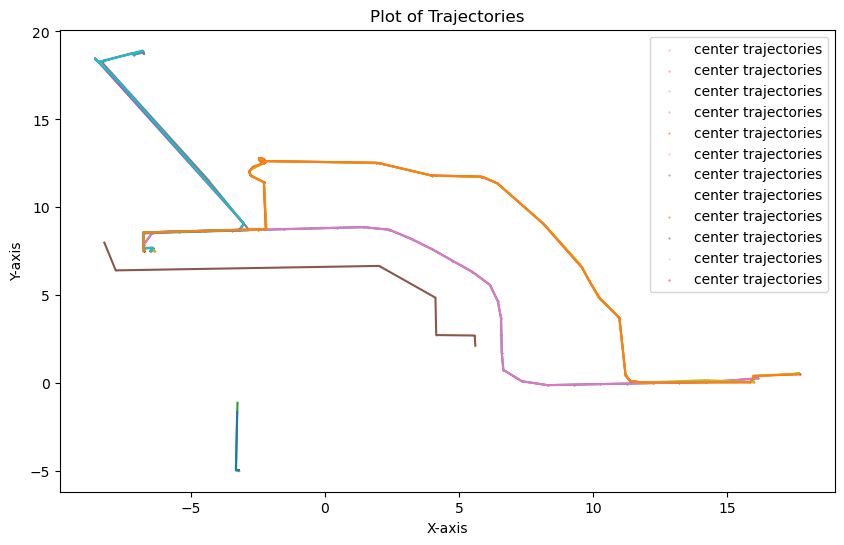

In [72]:
colors = ['salmon',
'tomato',
'darksalmon',
'coral',
'orangered',
'lightsalmon',
'sienna',
'seashell',
'chocolate',
'saddlebrown', 'lightgreen' ,'brown', 'blue']

fig, ax = plt.subplots(figsize=(10,6))
counter = 0

for points in center_traj[0]:
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    ax.scatter(x, y, c=colors[counter], label='center trajectories', s =0.1)  # Use the c parameter to specify the color, marker parameter to specify the marker shape, and linestyle parameter to specify the line style
    ax.plot(x,y)
    counter = counter +1
    
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

ax.set_title('Plot of Trajectories')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()

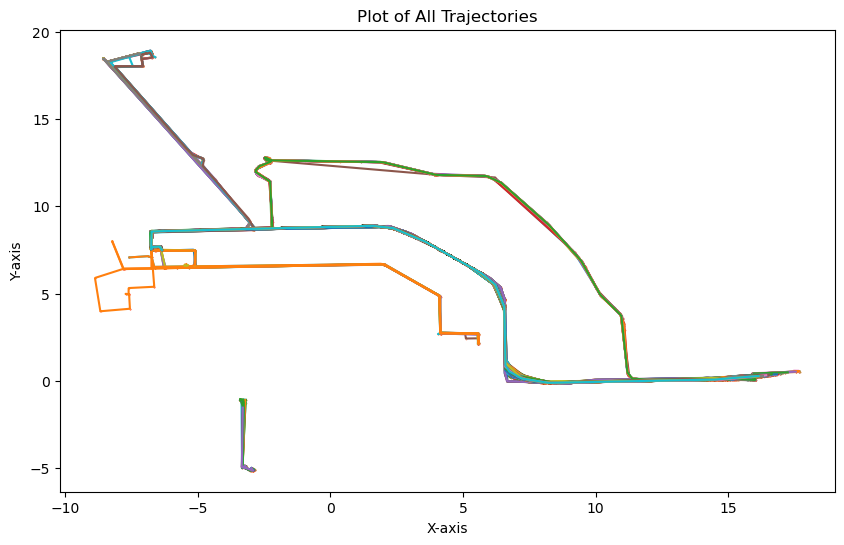

In [67]:
colors = ['salmon',
'tomato',
'darksalmon',
'coral',
'orangered',
'lightsalmon',
'sienna',
'seashell',
'chocolate',
'saddlebrown', 'lightgreen' ]

fig, ax = plt.subplots(figsize=(10,6))
counter = 0

for points in temp:
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    ax.scatter(x, y, c=colors[counter%10], s =0.1)  # Use the c parameter to specify the color, marker parameter to specify the marker shape, and linestyle parameter to specify the line style
    ax.plot(x,y)
    counter = counter +1
    
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

ax.set_title('Plot of All Trajectories')

# Display the plot
plt.show()

In [82]:
print(random_sum)

[2031.5130156008981, 2021.2939179043417, 2005.455090487569, 2002.1816535833295, 2004.7950890397585]


In [88]:
print(seeding_sum)

[1289.4350354711435, 1159.3859929798407, 1054.264903700124, 1052.5586561161595, 1051.5511882116566]


In [92]:
k = [4, 6, 8, 10, 12]

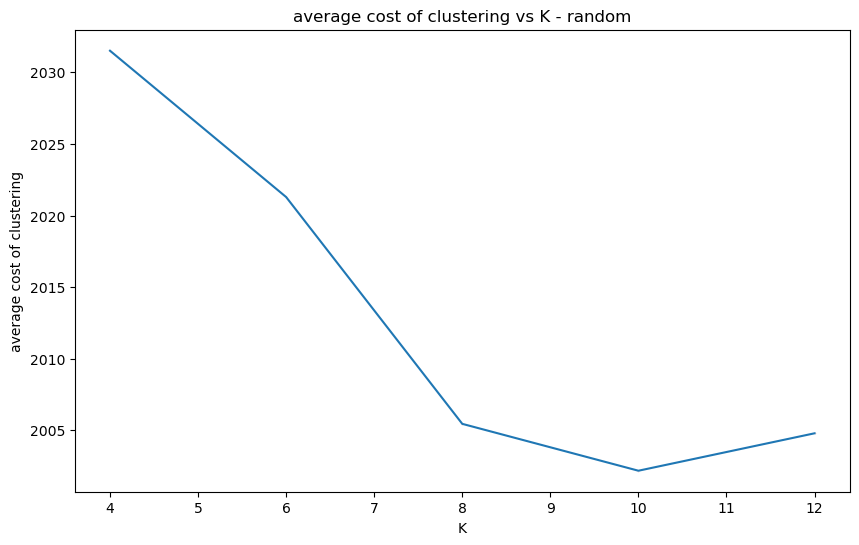

In [103]:
colors = ['salmon',
'tomato',
'darksalmon',
'coral',
'orangered',
'lightsalmon',
'sienna',
'seashell',
'chocolate',
'saddlebrown', 'lightgreen' ]

fig, ax = plt.subplots(figsize=(10,6))
counter = 0

y1 = random_sum
x = k
y2 = seeding_sum
ax.scatter(x, y1, c=colors[0], s =0.01, label='random')   
ax.plot(x, y)
    
ax.set_xlabel('K')
ax.set_ylabel('average cost of clustering')

ax.set_title('average cost of clustering vs K - random')

# Display the plot
plt.show()

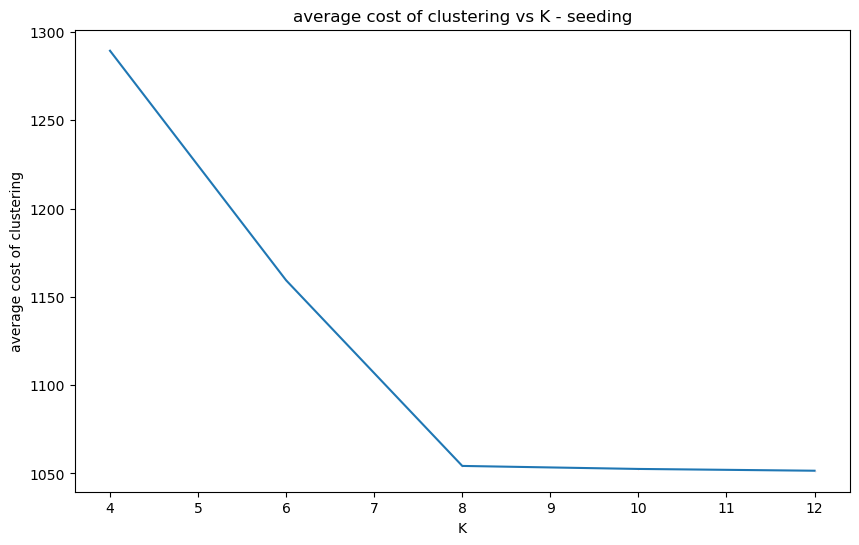

In [105]:
colors = ['salmon',
'tomato',
'darksalmon',
'coral',
'orangered',
'lightsalmon',
'sienna',
'seashell',
'chocolate',
'saddlebrown', 'lightgreen' ]

fig, ax = plt.subplots(figsize=(10,6))
counter = 0

y1 = random_sum
x = k
y2 = seeding_sum
ax.scatter(x, y2, c=colors[0], s =0.01, label='seeding')   
ax.plot(x, y2)
    
ax.set_xlabel('K')
ax.set_ylabel('average cost of clustering')

ax.set_title('average cost of clustering vs K - seeding')

# Display the plot
plt.show()